# Модель бинарной регрессии

Цель построения данной модели - вычислить признаки, отличающие автомобили марок BMW, Mercedes и Audi или показать, что их нет.

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc
from IPython.display import Latex

data = pd.read_csv('extended_data.csv', sep = ';', index_col=0)

## Дамми-переменные

In [43]:
manufacturer_dummies = pd.get_dummies(data.manufacturer, prefix='manufacturer', prefix_sep='_', dtype=int)

color_groups = ['black', 'white', 'grey_silver', 'blue_brown', 'red', 'other']
def color_group(x):
    if pd.isna(x):
        return np.nan
    for i in color_groups:
        if x in i:
            return i
    return 'other'

data['color_group'] = data['color'].apply(color_group)
color_dummies = pd.get_dummies(data.color_group, prefix='color_gr_', prefix_sep='_', dtype=int)


data['is_manual_transmission'] = data['transmission'].apply(lambda x : 1 if x == 'manual' else 0)

data['is_diesel'] = data['petrol_type'].apply(lambda x : 1 if x == 'дизель' else 0)
data['law_int'] = data['law'].apply(lambda x : 1 if x else 0)
data['sport_int'] = data['is_sport_line'].apply(lambda x : 1 if x else 0)
data['crossover_int'] = data['is_crossover'].apply(lambda x : 1 if x else 0)


data = pd.concat([data, manufacturer_dummies, color_dummies], axis=1)

print("Коэффициент цены: ", data["price"].mean())
print("Коэффициент пробега: ", data["mileage"].mean())

data["price"] = data["price"] / data["price"].mean()
data["mileage"] = data["mileage"] / data["mileage"].mean()


Коэффициент цены:  5445200.600705303
Коэффициент пробега:  121013.66929984471


## Строим три модели бинарной регрессии для производителей BMW, Audi, Mercedes

In [44]:
independent_vars =[ 'mileage', 'engine_volume_liters',
     'power_in_hp', 'color_gr__blue_brown', 'color_gr__grey_silver',
     'color_gr__other', 'color_gr__red', 'color_gr__white', 'is_manual_transmission', 'year', 'price', 'sport_int', 'crossover_int', 'owner_count', 'law_int']

In [45]:
data = data.dropna(subset=independent_vars)

## Модель для Audi

In [46]:
x_mult = data[independent_vars]
y = data[['manufacturer_Audi']]

In [47]:
x_mult = data[independent_vars]
y = data[['manufacturer_Audi']]
x_mult_constant = sm.add_constant(x_mult)
model1 = sm.Logit(y, x_mult_constant).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.353086
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      manufacturer_Audi   No. Observations:                10690
Model:                          Logit   Df Residuals:                    10674
Method:                           MLE   Df Model:                           15
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.3219
Time:                        00:07:34   Log-Likelihood:                -3774.5
converged:                       True   LL-Null:                       -5566.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.8161     15.981      0.239      0.811     -27.507      35.139
mileage                   -0.1941      0.049     -3.995      0.000      -0.289      -0.099
engine_volume_liters      -1.0469      0.081    -12.921      0.000      -1.206      -0.888
power_in_hp                0.0095      0.001     11.578      0.000       0.008       0.011
color_gr__blue_brown       0.2663      0.084      3.164      0.002       0.101       0.431
color_gr__grey_silver      0.1546      0.082      1.888      0.059      -0.006       0.315
color_gr__other            0.3998      0.128      3.129      0.002       0.149       0.650
color_gr__red              0.2949      0.147      2.008      0.045       0.007       0.583
color_gr__white            0.0268      0.080      0.333      0.739      -0.131       0.184
is_manual_transmission     0.7512      0.142      5.307      0.000       0.474       1.029
year                      -0.0013      0.008     -0.163      0.870      -0.017       0.014
price                     -1.4681      0.114    -12.837      0.000      -1.692      -1.244
sport_int                 -4.2270      0.145    -29.186      0.000      -4.511      -3.943
crossover_int             -0.1902      0.066     -2.869      0.004      -0.320      -0.060
owner_count               -0.0637      0.013     -4.791      0.000      -0.090      -0.038
law_int                   -0.0062      0.097     -0.064      0.949      -0.196       0.184
==========================================================================================
"""

In [48]:
equation = 'logit(p) = {:.4f}'.format(model1.params.iloc[0])  # Свободный член (intercept)

for i, param in enumerate(model1.params[1:], start=1):
    equation += ' + {:.4f} * {}'.format(param, x_mult_constant.columns[i])

print(equation)

logit(p) = 3.8161 + -0.1941 * mileage + -1.0469 * engine_volume_liters + 0.0095 * power_in_hp + 0.2663 * color_gr__blue_brown + 0.1546 * color_gr__grey_silver + 0.3998 * color_gr__other + 0.2949 * color_gr__red + 0.0268 * color_gr__white + 0.7512 * is_manual_transmission + -0.0013 * year + -1.4681 * price + -4.2270 * sport_int + -0.1902 * crossover_int + -0.0637 * owner_count + -0.0062 * law_int


In [49]:
display(Latex('$R^2$ = {:f}'.format(model1.prsquared)))
print('Model significance = {:f}'.format(model1.llr_pvalue))

<IPython.core.display.Latex object>

Model significance = 0.000000


In [50]:
coefs = pd.DataFrame()
coefs['Coefs'] = model1.params[1:]
coefs['Features'] = model1.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs['OddsRatio'] = np.exp(coefs.Coefs)
display(coefs)

,Coefs,OddsRatio
Features,,
mileage,-0.194123,0.823556
engine_volume_liters,-1.046885,0.351029
power_in_hp,0.009507,1.009552
color_gr__blue_brown,0.266334,1.305171
color_gr__grey_silver,0.154562,1.167146
color_gr__other,0.399820,1.491556
color_gr__red,0.294855,1.342932
color_gr__white,0.026782,1.027143
is_manual_transmission,0.751156,2.119449


In [51]:
def yes_no(p_value, level = 0.05):
    if abs(p_value) < level:
        return 'significant'
    else:
        return 'non-significant'
    

pvals = pd.DataFrame()
pvals['p_values'] = model1.pvalues[1:]
pvals['5% level']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = model1.params.index[1:]
pvals.set_index('Features',inplace=True)
pvals['10% level'] = model1.pvalues[1:].apply(lambda x: yes_no(x, level=0.1))
pvals

,p_values,5% level,10% level
Features,,,
mileage,0.000,significant,significant
engine_volume_liters,0.000,significant,significant
power_in_hp,0.000,significant,significant
color_gr__blue_brown,0.002,significant,significant
color_gr__grey_silver,0.059,non-significant,significant
color_gr__other,0.002,significant,significant
color_gr__red,0.045,significant,significant
color_gr__white,0.739,non-significant,non-significant
is_manual_transmission,0.000,significant,significant


In [52]:
p = stats.kstest(model1.resid_generalized, 'norm', args=(model1.resid_generalized.mean(), model1.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


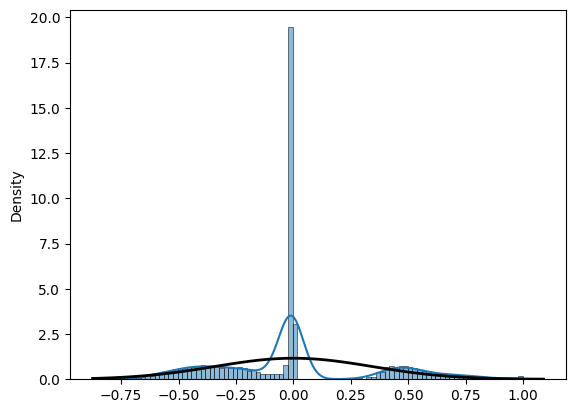

In [53]:
sns.histplot(model1.resid_generalized, kde=True, stat='density')
mean_resid = np.mean(model1.resid_generalized)
std_resid = np.std(model1.resid_generalized)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_resid, std_resid)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [54]:
vifs = np.array([vif(model1.model.exog, i) for i in range(model1.model.exog.shape[1])])
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model1.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
11,1.068533,sport_int
14,1.089313,law_int
6,1.096977,color_gr__red
5,1.108503,color_gr__other
12,1.207719,crossover_int
3,1.211967,color_gr__blue_brown
4,1.215553,color_gr__grey_silver
7,1.253912,color_gr__white
13,1.754773,owner_count
8,2.007892,is_manual_transmission


Модель статистически не значима, и объясняет 32,2% наблюдений.
Значимые предикторы: пробег, цена, объем двигателя, мощность, белый, серый или черный цвет, коробка передач, принадлежность к спортивной линейке или линейке кроссоверов, число владельцев. Распределение остатков отличается от нормального распределения, наблюдается сдвиг влево. Также есть проблема мультиколлинеарности для цвета. 


Признаки того, что случайный автомобиль - Audi согласно данной модели:

    - Меньший пробег
    - Более низкая цена
    - Более низкий объем двигателя
    - Более высокая мощность
    - Автомобиль не серый, белый или черный
    - Механическая коробка передач
    - Автомобиль не принадлежит к спортивной линейке
    - Автомобиль - не кроссовер
    - У автомобиля меньше предыдущих владельцев
    - Более ранний год выпуска 


## Модель для BMW

In [63]:
x_mult = data[independent_vars]
y = data[['manufacturer_BMW']]
x_mult_constant = sm.add_constant(x_mult)
model1 = sm.Logit(y, x_mult_constant).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.644920
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       manufacturer_BMW   No. Observations:                10690
Model:                          Logit   Df Residuals:                    10674
Method:                           MLE   Df Model:                           15
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                 0.04059
Time:                        00:14:58   Log-Likelihood:                -6894.2
converged:                       True   LL-Null:                       -7185.9
Covariance Type:            nonrobust   LLR p-value:                1.198e-114
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -107.0689     12.691     -8.437      0.000    -131.942     -82.196
mileage                    0.1604      0.039      4.140      0.000       0.084       0.236
engine_volume_liters       0.3282      0.052      6.356      0.000       0.227       0.429
power_in_hp               -0.0028      0.000     -5.530      0.000      -0.004      -0.002
color_gr__blue_brown       0.1038      0.062      1.682      0.093      -0.017       0.225
color_gr__grey_silver      0.1752      0.059      2.963      0.003       0.059       0.291
color_gr__other           -0.0053      0.104     -0.051      0.959      -0.210       0.199
color_gr__red             -0.1929      0.116     -1.666      0.096      -0.420       0.034
color_gr__white            0.0806      0.057      1.416      0.157      -0.031       0.192
is_manual_transmission     0.4055      0.122      3.336      0.001       0.167       0.644
year                       0.0526      0.006      8.369      0.000       0.040       0.065
price                     -0.1342      0.049     -2.764      0.006      -0.229      -0.039
sport_int                  0.7683      0.042     18.299      0.000       0.686       0.851
crossover_int              0.4036      0.045      8.908      0.000       0.315       0.492
owner_count                0.0243      0.011      2.278      0.023       0.003       0.045
law_int                   -0.2294      0.074     -3.118      0.002      -0.374      -0.085
==========================================================================================
"""

In [64]:
equation = 'logit(p) = {:.4f}'.format(model1.params.iloc[0])  # Свободный член (intercept)

for i, param in enumerate(model1.params[1:], start=1):
    equation += ' + {:.4f} * {}'.format(param, x_mult_constant.columns[i])

print(equation)
display(Latex(('$R^2$ = {:f}'.format(model1.prsquared))))
print('Model significance = {:f}'.format(model1.llr_pvalue))

coefs = pd.DataFrame()
coefs['Coefs'] = model1.params[1:]
coefs['Features'] = model1.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs['OddsRatio'] = np.exp(coefs.Coefs)
display(coefs)


def yes_no(p_value, level = 0.05):
    if abs(p_value) < level:
        return 'significant'
    else:
        return 'non-significant'
    

pvals = pd.DataFrame()
pvals['p_values'] = model1.pvalues[1:]
pvals['5% level']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = model1.params.index[1:]
pvals.set_index('Features',inplace=True)
pvals['10% level'] = model1.pvalues[1:].apply(lambda x: yes_no(x, level=0.1))
pvals

logit(p) = -107.0689 + 0.1604 * mileage + 0.3282 * engine_volume_liters + -0.0028 * power_in_hp + 0.1038 * color_gr__blue_brown + 0.1752 * color_gr__grey_silver + -0.0053 * color_gr__other + -0.1929 * color_gr__red + 0.0806 * color_gr__white + 0.4055 * is_manual_transmission + 0.0526 * year + -0.1342 * price + 0.7683 * sport_int + 0.4036 * crossover_int + 0.0243 * owner_count + -0.2294 * law_int


<IPython.core.display.Latex object>

Model significance = 0.000000


,Coefs,OddsRatio
Features,,
mileage,0.160378,1.173954
engine_volume_liters,0.328203,1.388471
power_in_hp,-0.002758,0.997245
color_gr__blue_brown,0.103805,1.109384
color_gr__grey_silver,0.175203,1.191488
color_gr__other,-0.005337,0.994678
color_gr__red,-0.192918,0.824550
color_gr__white,0.080571,1.083905
is_manual_transmission,0.405468,1.500004


,p_values,5% level,10% level
Features,,,
mileage,0.000,significant,significant
engine_volume_liters,0.000,significant,significant
power_in_hp,0.000,significant,significant
color_gr__blue_brown,0.093,non-significant,significant
color_gr__grey_silver,0.003,significant,significant
color_gr__other,0.959,non-significant,non-significant
color_gr__red,0.096,non-significant,significant
color_gr__white,0.157,non-significant,non-significant
is_manual_transmission,0.001,significant,significant


P-value: 0.000


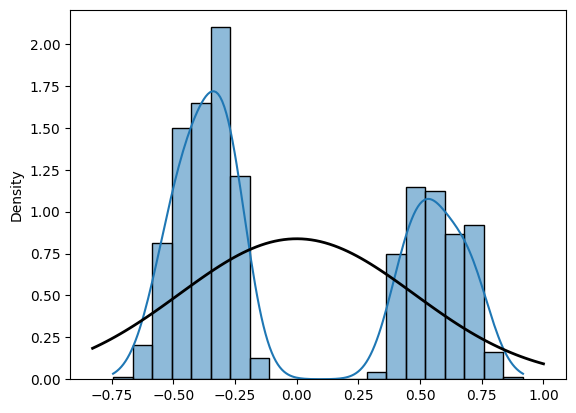

In [65]:
p = stats.kstest(model1.resid_generalized, 'norm', args=(model1.resid_generalized.mean(), model1.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))
sns.histplot(model1.resid_generalized, kde=True, stat='density')
mean_resid = np.mean(model1.resid_generalized)
std_resid = np.std(model1.resid_generalized)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_resid, std_resid)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [66]:
vifs = np.array([vif(model1.model.exog, i) for i in range(model1.model.exog.shape[1])])
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model1.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
11,1.068533,sport_int
14,1.089313,law_int
6,1.096977,color_gr__red
5,1.108503,color_gr__other
12,1.207719,crossover_int
3,1.211967,color_gr__blue_brown
4,1.215553,color_gr__grey_silver
7,1.253912,color_gr__white
13,1.754773,owner_count
8,2.007892,is_manual_transmission


Модель статистически не значима, объясняет только 4% наблюдений. Значимых признаков, указывающих на то, что автомобиль BMW меньше. 
Также существует проблема мультиколлинеарности для цвета.
Признаки того, что случайный автомобиль - BMW согласно данной модели:
- Больший пробег
- Более низкая цена
- Больший объем двигателя
- Меньшая мощность
- Автомобиль серый или серебряный
- Механическая коробка передач
- Автомобиль принадлежит к спортивной линейке
- Автомобиль - кроссовер
- У автомобиля больше предыдущих владельцев
- Проблемы с законом


## Модель для Mercedes

In [67]:
x_mult = data[independent_vars]
y = data[['manufacturer_Mercedes-Benz']]
x_mult_constant = sm.add_constant(x_mult)
model1 = sm.Logit(y, x_mult_constant).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.631569
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     manufacturer_Mercedes-Benz   No. Observations:                10690
Model:                                  Logit   Df Residuals:                    10674
Method:                                   MLE   Df Model:                           15
Date:                        Mon, 26 Feb 2024   Pseudo R-squ.:                 0.05355
Time:                                00:29:28   Log-Likelihood:                -6751.5
converged:                               True   LL-Null:                       -7133.4
Covariance Type:                    nonrobust   LLR p-value:                4.308e-153
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     74.1100     12.591      5.886      0.000      49.432      98.788
mileage                   -0.0456      0.039     -1.163      0.245      -0.122       0.031
engine_volume_liters       0.2549      0.052      4.879      0.000       0.153       0.357
power_in_hp               -0.0022      0.001     -4.332      0.000      -0.003      -0.001
color_gr__blue_brown      -0.2642      0.064     -4.159      0.000      -0.389      -0.140
color_gr__grey_silver     -0.2593      0.060     -4.291      0.000      -0.378      -0.141
color_gr__other           -0.2553      0.106     -2.408      0.016      -0.463      -0.047
color_gr__red             -0.0262      0.111     -0.235      0.814      -0.245       0.192
color_gr__white           -0.1041      0.057     -1.811      0.070      -0.217       0.009
is_manual_transmission    -1.0540      0.131     -8.048      0.000      -1.311      -0.797
year                      -0.0374      0.006     -6.005      0.000      -0.050      -0.025
price                      0.5534      0.052     10.668      0.000       0.452       0.655
sport_int                  0.8560      0.043     20.089      0.000       0.773       0.940
crossover_int             -0.2586      0.046     -5.572      0.000      -0.350      -0.168
owner_count                0.0119      0.011      1.109      0.267      -0.009       0.033
law_int                    0.2158      0.076      2.824      0.005       0.066       0.366
==========================================================================================
"""

In [68]:
equation = 'logit(p) = {:.4f}'.format(model1.params.iloc[0])  # Свободный член (intercept)

for i, param in enumerate(model1.params[1:], start=1):
    equation += ' + {:.4f} * {}'.format(param, x_mult_constant.columns[i])

print(equation)
display(Latex(('$R^2$ = {:f}'.format(model1.prsquared))))
print('Model significance = {:f}'.format(model1.llr_pvalue))

coefs = pd.DataFrame()
coefs['Coefs'] = model1.params[1:]
coefs['Features'] = model1.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs['OddsRatio'] = np.exp(coefs.Coefs)
display(coefs)


def yes_no(p_value, level = 0.05):
    if abs(p_value) < level:
        return 'significant'
    else:
        return 'non-significant'
    

pvals = pd.DataFrame()
pvals['p_values'] = model1.pvalues[1:]
pvals['5% level']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = model1.params.index[1:]
pvals.set_index('Features',inplace=True)
pvals['10% level'] = model1.pvalues[1:].apply(lambda x: yes_no(x, level=0.1))
pvals

logit(p) = 74.1100 + -0.0456 * mileage + 0.2549 * engine_volume_liters + -0.0022 * power_in_hp + -0.2642 * color_gr__blue_brown + -0.2593 * color_gr__grey_silver + -0.2553 * color_gr__other + -0.0262 * color_gr__red + -0.1041 * color_gr__white + -1.0540 * is_manual_transmission + -0.0374 * year + 0.5534 * price + 0.8560 * sport_int + -0.2586 * crossover_int + 0.0119 * owner_count + 0.2158 * law_int


<IPython.core.display.Latex object>

Model significance = 0.000000


,Coefs,OddsRatio
Features,,
mileage,-0.045608,0.955416
engine_volume_liters,0.254897,1.290329
power_in_hp,-0.002185,0.997817
color_gr__blue_brown,-0.264205,0.767816
color_gr__grey_silver,-0.259319,0.771577
color_gr__other,-0.255316,0.774671
color_gr__red,-0.026218,0.974123
color_gr__white,-0.104089,0.901145
is_manual_transmission,-1.054007,0.348539


,p_values,5% level,10% level
Features,,,
mileage,0.245,non-significant,non-significant
engine_volume_liters,0.000,significant,significant
power_in_hp,0.000,significant,significant
color_gr__blue_brown,0.000,significant,significant
color_gr__grey_silver,0.000,significant,significant
color_gr__other,0.016,significant,significant
color_gr__red,0.814,non-significant,non-significant
color_gr__white,0.070,non-significant,significant
is_manual_transmission,0.000,significant,significant


P-value: 0.000


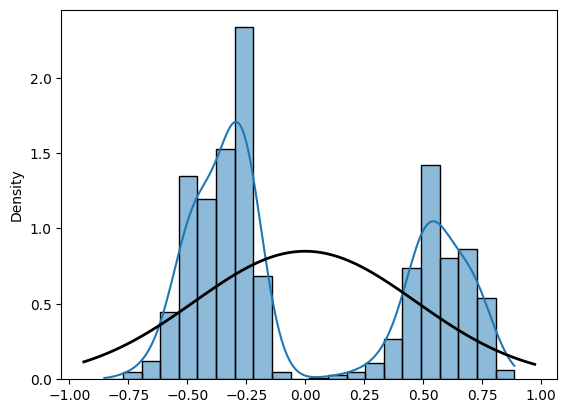

In [61]:
p = stats.kstest(model1.resid_generalized, 'norm', args=(model1.resid_generalized.mean(), model1.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))
sns.histplot(model1.resid_generalized, kde=True, stat='density')
mean_resid = np.mean(model1.resid_generalized)
std_resid = np.std(model1.resid_generalized)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_resid, std_resid)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [62]:
vifs = np.array([vif(model1.model.exog, i) for i in range(model1.model.exog.shape[1])])
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model1.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
11,1.068533,sport_int
14,1.089313,law_int
6,1.096977,color_gr__red
5,1.108503,color_gr__other
12,1.207719,crossover_int
3,1.211967,color_gr__blue_brown
4,1.215553,color_gr__grey_silver
7,1.253912,color_gr__white
13,1.754773,owner_count
8,2.007892,is_manual_transmission


Данная модель не значима и описывает только 5% наблюдений. Значимыми переменными являются объем двигателя, мощность, коробка передач, год, цена, принадлежность к спортивным или кроссоверам автомобилям, и законодательный статус. Также наблюдается проблема мультиколлинеарности по цвету.

Среднестатистический автомобиль марки Mercedes: 

    - Более высокий объем двигателя
    - Более низкая мощность
    - Автоматическая коробка передач
    - Более поздний год выпуска
    - Более высокая цена
    - Спортивная линейка
    - Большее число владельцев
    - Проблемы с законом